In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [2]:
data = pd.read_csv('data_artiks.csv', sep = ';')
data.head()

,week_start,impressions_dm,impressions_inst,impressions_nsp,impressions_auddig,impressions_audtr,impressions_vidtr,impressions_viddig,impressions_so,impressions_on,...,costs_so,costs_on,costs_sem,sales,macro_ics_all,macro_gas_dpg,stores_count,discount_edw,discount_pdm,holiday
0,03.08.2014,4863885,29087520,2421933,692315,37778097,10038746,2111112,0,3271007,...,0.0,61364.75,355954.51,72051457.64,82.5,3.595,716.285714,0.0,0.368029,NaN
1,10.08.2014,20887502,8345120,3984494,475810,12063657,9847977,587184,0,4260715,...,0.0,132643.90,336306.72,78794770.54,82.5,3.5820000000000003,716.428571,0.0,0.360911,NaN
2,17.08.2014,11097724,17276800,1846832,784732,5770115,7235336,1015658,0,4405992,...,0.0,76741.27,344787.96,70071185.56,82.5,3.549,717.000000,0.0,0.344832,NaN
3,24.08.2014,1023446,18468480,2394834,1032301,12174000,8625122,2149160,0,6638320,...,0.0,193043.55,365495.11,68642464.59,82.5,3.532,717.000000,0.0,0.356973,NaN
4,31.08.2014,21109811,26659920,3312008,400456,31656134,19785657,2408661,0,4347752,...,0.0,249612.89,401789.35,86190784.65,84.6,3.5360000000000005,717.000000,0.0,0.359990,Labor Day


#### Предобработка данных

In [3]:
data.isna().sum()

week_start              0
impressions_dm          0
impressions_inst        0
impressions_nsp         0
impressions_auddig      0
impressions_audtr       0
impressions_vidtr       0
impressions_viddig      0
impressions_so          0
impressions_on          0
impressions_em          0
impressions_sms         0
impressions_aff         0
impressions_sem         0
costs_dm                0
costs_inst              0
costs_nsp               0
costs_auddig            0
costs_audtr             0
costs_vidtr             0
costs_viddig            0
costs_so                0
costs_on                0
costs_sem               0
sales                   0
macro_ics_all           0
macro_gas_dpg           0
stores_count            0
discount_edw            0
discount_pdm            0
holiday               142
dtype: int64

In [4]:
data['holiday'].value_counts()

MLK                                                4
Labor Day                                          4
Mother's Day                                       4
Memorial Day                                       4
Cyber Monday                                       4
Veterans Day                                       4
July 4th                                           4
Columbus Day                                       4
Easter                                             4
Prime Day                                          4
Father's Day                                       4
Black Friday/Pre Thanksgiving/Thanksgiving         4
Green Monday                                       3
Presidents Day                                     3
Valentine's Day                                    3
NYE/New Year's Day                                 3
Christmas Day/Christmas Eve/Day after Christmas    2
Christmas Day/Day after Christmas                  1
Christmas Day/Day after Christmas/NYE         

Создаю новый класс для недель без праздников

In [5]:
data['holiday'].fillna('no holiday', inplace = True)

In [6]:
costs = [col for col in data.columns if 'costs_' in col]

Перевожу время в удобный формат

In [7]:
data['week_start'] = pd.to_datetime(data['week_start'])

In [8]:
data['year'] = data.week_start.dt.year
data['month'] = data.week_start.dt.month
data['day'] = data.week_start.dt.day


In [9]:
data.dtypes

week_start            datetime64[ns]
impressions_dm                 int64
impressions_inst               int64
impressions_nsp                int64
impressions_auddig             int64
impressions_audtr              int64
impressions_vidtr              int64
impressions_viddig             int64
impressions_so                 int64
impressions_on                 int64
impressions_em                 int64
impressions_sms                int64
impressions_aff                int64
impressions_sem                int64
costs_dm                     float64
costs_inst                   float64
costs_nsp                    float64
costs_auddig                  object
costs_audtr                  float64
costs_vidtr                  float64
costs_viddig                 float64
costs_so                     float64
costs_on                     float64
costs_sem                    float64
sales                        float64
macro_ics_all                float64
macro_gas_dpg                 object
s

#### Нахожу и заменяю на среднее все "непонятные" значения

In [10]:
# колонки где есть такие значения
non_num_cols = []
for i in data.columns:
    try:
        list(map(float, data[i]))
    except:
        non_num_cols.append(i)
non_num_cols

['week_start', 'costs_auddig', 'macro_gas_dpg', 'holiday']

In [11]:
non_num = []
sum = 0
for i in data.costs_auddig:
    try:
        sum += float(i)
    except:
        non_num.append(i)
non_num

['Jan.62', 'Jan.62']

In [12]:
mean = np.average(list(map(float, data.costs_auddig[data.costs_auddig != 'Jan.62'])))
data.costs_auddig[data.costs_auddig == 'Jan.62'] = mean

In [13]:
non_num = []
sum = 0
for i in data.macro_gas_dpg:
    try:
        sum += float(i)
    except:
        non_num.append(i)
non_num

['Feb.57',
 'Feb.57',
 'Feb.72',
 'Feb.24',
 'Feb.44',
 'Feb.31',
 'Feb.51',
 'Feb.75']

In [14]:
for i in range(len(data.macro_gas_dpg)):
    if  data.loc[i, 'macro_gas_dpg'] in non_num:
        data.loc[i, 'macro_gas_dpg'] = sum/(len(data) - len(non_num))

In [15]:
data.drop('week_start', axis = 1, inplace = True)

Кодирую названия праздников

In [16]:
le = LabelEncoder()

data['holiday'] = le.fit_transform(data['holiday'])

In [17]:
data.costs_auddig = data.costs_auddig.astype('float64')
data.macro_gas_dpg = data.macro_gas_dpg.astype('float64')
data.dtypes

impressions_dm          int64
impressions_inst        int64
impressions_nsp         int64
impressions_auddig      int64
impressions_audtr       int64
impressions_vidtr       int64
impressions_viddig      int64
impressions_so          int64
impressions_on          int64
impressions_em          int64
impressions_sms         int64
impressions_aff         int64
impressions_sem         int64
costs_dm              float64
costs_inst            float64
costs_nsp             float64
costs_auddig          float64
costs_audtr           float64
costs_vidtr           float64
costs_viddig          float64
costs_so              float64
costs_on              float64
costs_sem             float64
sales                 float64
macro_ics_all         float64
macro_gas_dpg         float64
stores_count          float64
discount_edw          float64
discount_pdm          float64
holiday                 int32
year                    int64
month                   int64
day                     int64
dtype: obj

Разбиваю выборку на тестовую и обучающую
(Почему делаю не случайное разбиение, а такое: потому что кажется что данные должны следовать в хронологическом порядке, чтобы показать адекватный результат)

In [18]:
X = data.drop('sales', axis = 1)
y = data['sales']

X_train, y_train = X[:167], y[:167]
X_test, y_test = X[167:], y[167:]

### Пробую разные модели

In [19]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

model = CatBoostRegressor(verbose = 100)
model.fit(X_train, y_train)

pred1 = model.predict(X_test)
print('R^2', r2_score(y_test, pred1))
print('MAE:',mean_absolute_error(y_test, pred1))
print(mean_absolute_error(y_test, pred1)/np.mean(y))

Learning rate set to 0.028382
0:	learn: 53409122.2362058	total: 54.6ms	remaining: 54.5s
100:	learn: 26729429.4693428	total: 348ms	remaining: 3.1s
200:	learn: 17614824.4488252	total: 639ms	remaining: 2.54s
300:	learn: 10888852.9270907	total: 930ms	remaining: 2.16s
400:	learn: 6625034.9309672	total: 1.23s	remaining: 1.84s
500:	learn: 4180478.1013207	total: 1.53s	remaining: 1.52s
600:	learn: 2629869.5180392	total: 1.81s	remaining: 1.21s
700:	learn: 1648821.0528119	total: 2.1s	remaining: 894ms
800:	learn: 1031364.2450152	total: 2.37s	remaining: 588ms
900:	learn: 675523.5718567	total: 2.67s	remaining: 293ms
999:	learn: 439220.3208887	total: 3.05s	remaining: 0us
R^2 0.5358608957876734
MAE: 28430235.596643917
0.26311073766103854


In [ ]:
params = {'depth':[8,9,10],
              'iterations':[250,100,500,1000],
              'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
              'l2_leaf_reg':[3,1,5,10,100]}
model = CatBoostRegressor(verbose = 100)

grid_search_result = model.grid_search(params,
                                           X=X_train,
                                           y=y_train,
                                           cv=1,
                                           partition_random_seed=42,
                                           plot=True)

Другая моделька

In [20]:
model1 = XGBRegressor(random_state = 42, n_estimators = 1000, learning_rate = 0.3)
model1.fit(X_train, y_train)

pred2 = model1.predict(X_test)
print('R^2', r2_score(y_test, pred2))
print('MAE:',mean_absolute_error(y_test, pred2))
print(mean_absolute_error(y_test, pred2)/np.mean(y))

R^2 0.5867892709330711
MAE: 24842443.60976191
0.22990712269154728


In [21]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': (500, 1000, 1500),
    'learning_rate': [0.3, 0.1, 0.01, 0.05]
}
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(model1, parameters, scoring = 'neg_mean_absolute_error', verbose = False)
gs.fit(X_train, y_train)

##### Значимость Признаков

<AxesSubplot:>

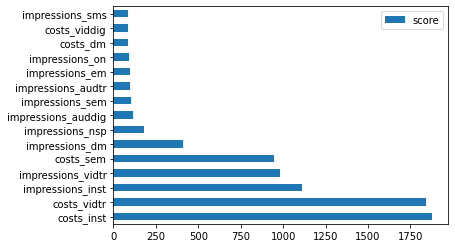

In [22]:
feature_important = model1.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

dat = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)[:15]
dat.plot(kind='barh')

##### Cмотрю как модель улавливает тренд

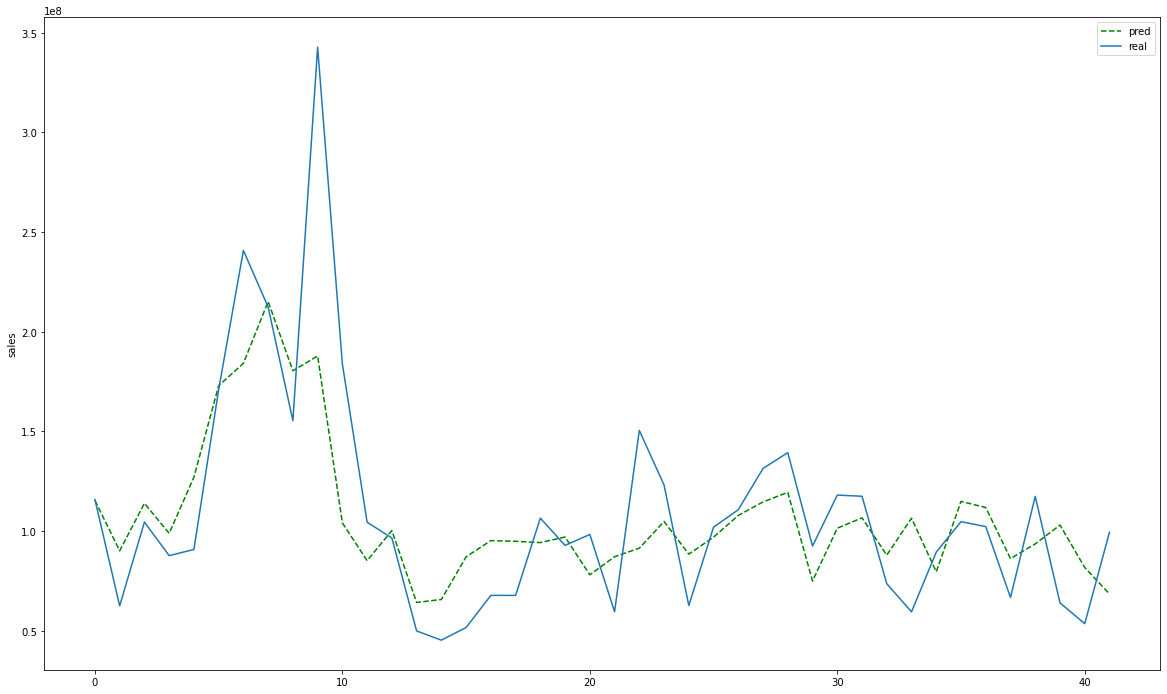

In [23]:
plt.figure(figsize=(20, 12))
plt.plot(np.arange(len(pred2)), pred2,'--',  label='pred', color = 'green')
plt.plot(np.arange(len(pred2)), y_test, label='real')
plt.ylabel('sales')
plt.legend()
plt.show()

#### Тут я решил впилить простенькую нейросетку, но попытка не увенчалась успехом

In [132]:
import keras
from keras.optimizers import Adam

In [134]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data.drop(['sales', 'holiday'], axis = 1)[:167])

StandardScaler()

In [136]:
col = data.drop(['sales', 'holiday'], axis = 1).columns
X = pd.DataFrame(scaler.transform(data.drop(['sales', 'holiday'], axis = 1)), columns = col).join(pd.get_dummies(data['holiday']))
y = data['sales']

X_train, y_train = X[:167], y[:167]
X_test, y_test = X[167:], y[167:]

In [154]:
model = keras.Sequential()
model.add(keras.layers.Dense(8, input_shape=(54,)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(2))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Dense(1))

In [155]:
opt = Adam(lr=0.3)
model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['mean_squared_error'])
history = model.fit(X_train, y_train,
                    batch_size=5,
                    epochs=1000,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/1000
30/30 [==============================] - 1s 10ms/step - loss: 15276888741490028.0000 - mean_squared_error: 15276888741490028.0000 - val_loss: 9000569972719616.0000 - val_mean_squared_error: 9000569972719616.0000
Epoch 2/1000
30/30 [==============================] - 0s 3ms/step - loss: 15034455640963006.0000 - mean_squared_error: 15034455640963006.0000 - val_loss: 8827997113024512.0000 - val_mean_squared_error: 8827997113024512.0000
Epoch 3/1000
30/30 [==============================] - 0s 3ms/step - loss: 13388620640178836.0000 - mean_squared_error: 13388620640178836.0000 - val_loss: 6564918178349056.0000 - val_mean_squared_error: 6564918178349056.0000
Epoch 4/1000
30/30 [==============================] - 0s 3ms/step - loss: 10533964496172990.0000 - mean_squared_error: 10533964496172990.0000 - val_loss: 3709118187569152.0000 - val_mean_squared_error: 3709118187569152.0000
Epoch 5/1000
30/30 [==============================] - 0s 3ms/step - loss: 7730167034218562.0000 - mean_

In [156]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


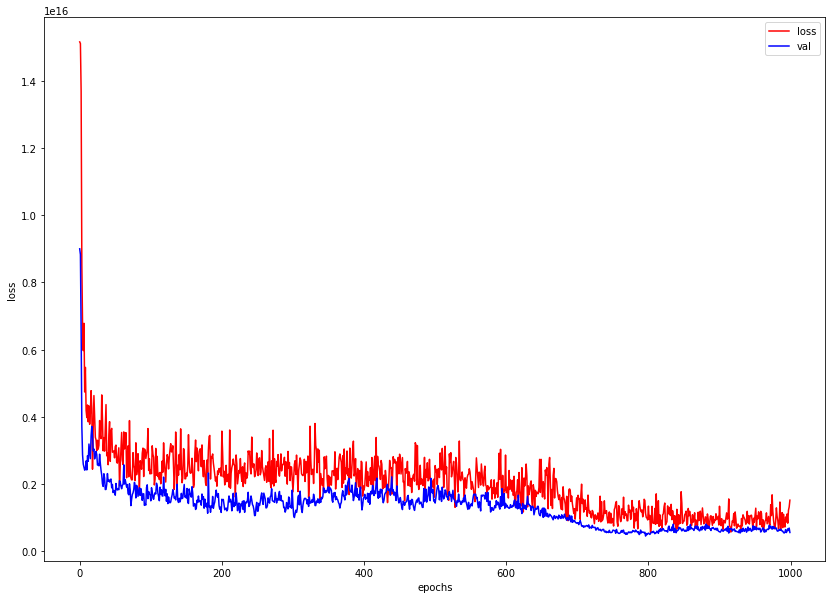

In [157]:
plt.figure(figsize=(14, 10))
plt.plot(np.arange(1000), history.history['loss'],  label='loss', color = 'red')
plt.plot(np.arange(1000), history.history['val_loss'], label='val', color = 'blue')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [158]:
score = model.evaluate(X_test, y_test, batch_size=5)

9/9 [==============================] - 0s 1ms/step - loss: 3157451650105344.0000 - mean_squared_error: 3157451650105344.0000


In [159]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 8)                 440       
_________________________________________________________________
activation_9 (Activation)    (None, 8)                 0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 36        
_________________________________________________________________
activation_10 (Activation)   (None, 4)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 10        
_________________________________________________________________
activation_11 (Activation)   (None, 2)                

### 2 задание

In [182]:
X = data.drop('sales', axis = 1)
y = data['sales']

X_train, y_train = X[:167], y[:167]
X_test, y_test = X[167:], y[167:]

model = XGBRegressor(verbose = 100, random_state = 42, n_estimators = 1000, learning_rate = 0.3)

model.fit(X, y)

[11:20:08] WARNING: ..\src\learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbose=100,
             verbosity=None)

In [183]:
costs = [col for col in data.columns if 'costs_' in col]
impres = [col for col in data.columns if 'impressions_' in col]

In [184]:
chanels = [['costs_dm', 'impressions_dm'], ['costs_inst', 'impressions_inst'], ['costs_nsp', 'impressions_nsp'],
          ['costs_auddig', 'impressions_auddig'], ['costs_audtr', 'impressions_audtr'], ['costs_vidtr', 'impressions_vidtr'],
          ['costs_viddig', 'impressions_viddig'], ['costs_so', 'impressions_so'], ['costs_on', 'impressions_on'],
          ['costs_sem', 'impressions_sem'], ['impressions_em'], ['impressions_sms'], ['impressions_aff']]

In [185]:
new_sales = []
for i in chanels:
    X_change = X.copy()
    X_change[i] = 0
    new_sales.append(model.predict(X_change))
    

In [186]:
chanels_names = ['without ' + i[12:] for i in impres]

In [187]:
res = pd.DataFrame()
res['real'] = [np.average(y)/np.average(y)]
for i in range(len(new_sales)):
    res[chanels_names[i]] = [np.average(new_sales[i])/np.average(y)]

<AxesSubplot:>

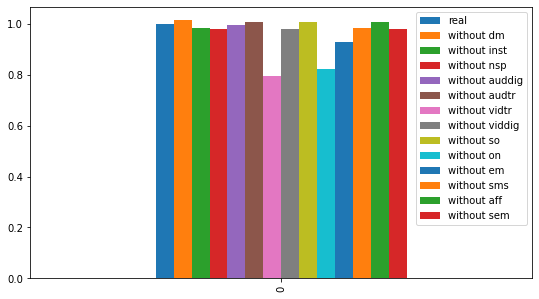

In [188]:
res.plot(kind='bar', figsize = (9 ,5))

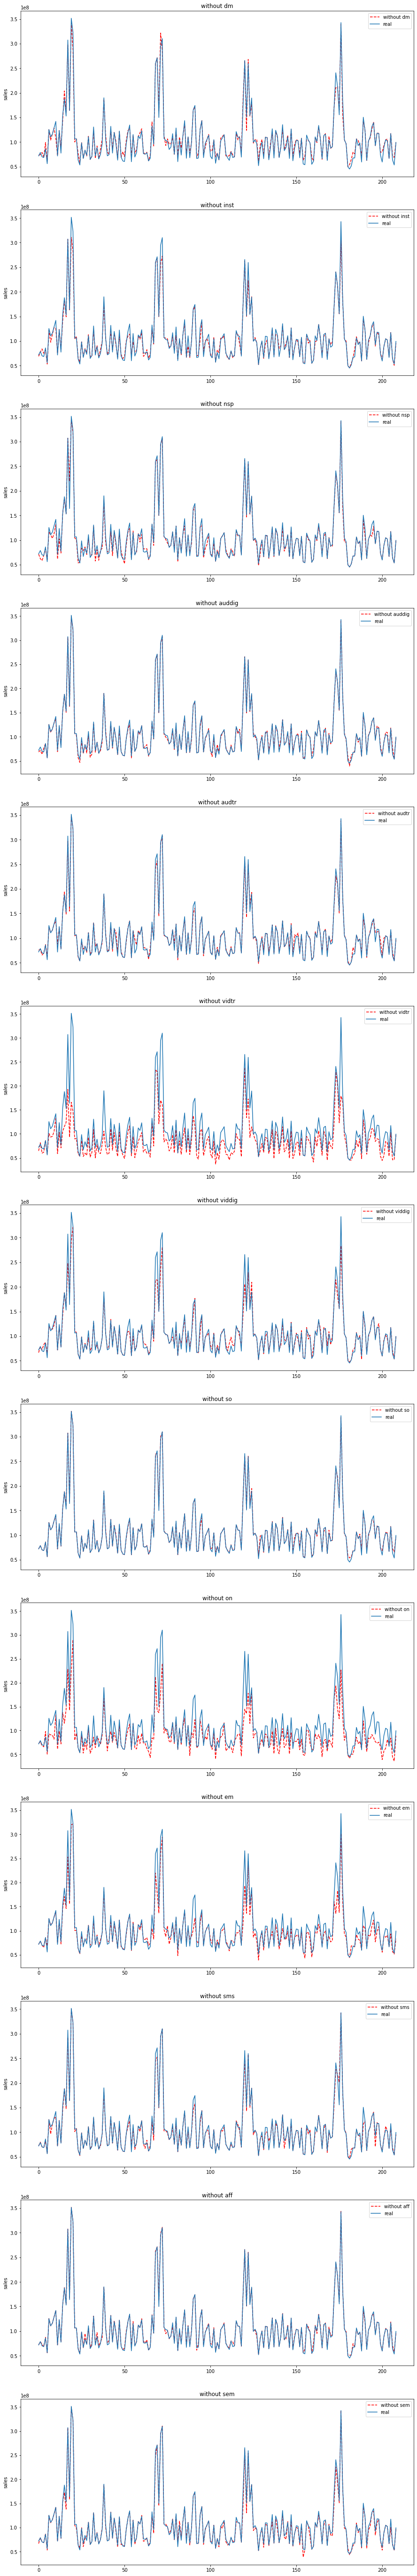

In [189]:
fig, ax = plt.subplots(13, 1, figsize=(15, 100))
for i in range(len(new_sales)):
    plt.subplot(13, 1, i+1)
    plt.title(chanels_names[i])
    plt.plot(np.arange(len(y)), new_sales[i],'--',  label=chanels_names[i], color = 'red')
    plt.plot(np.arange(len(y)), y, label='real')
    plt.ylabel('sales')
    plt.legend()

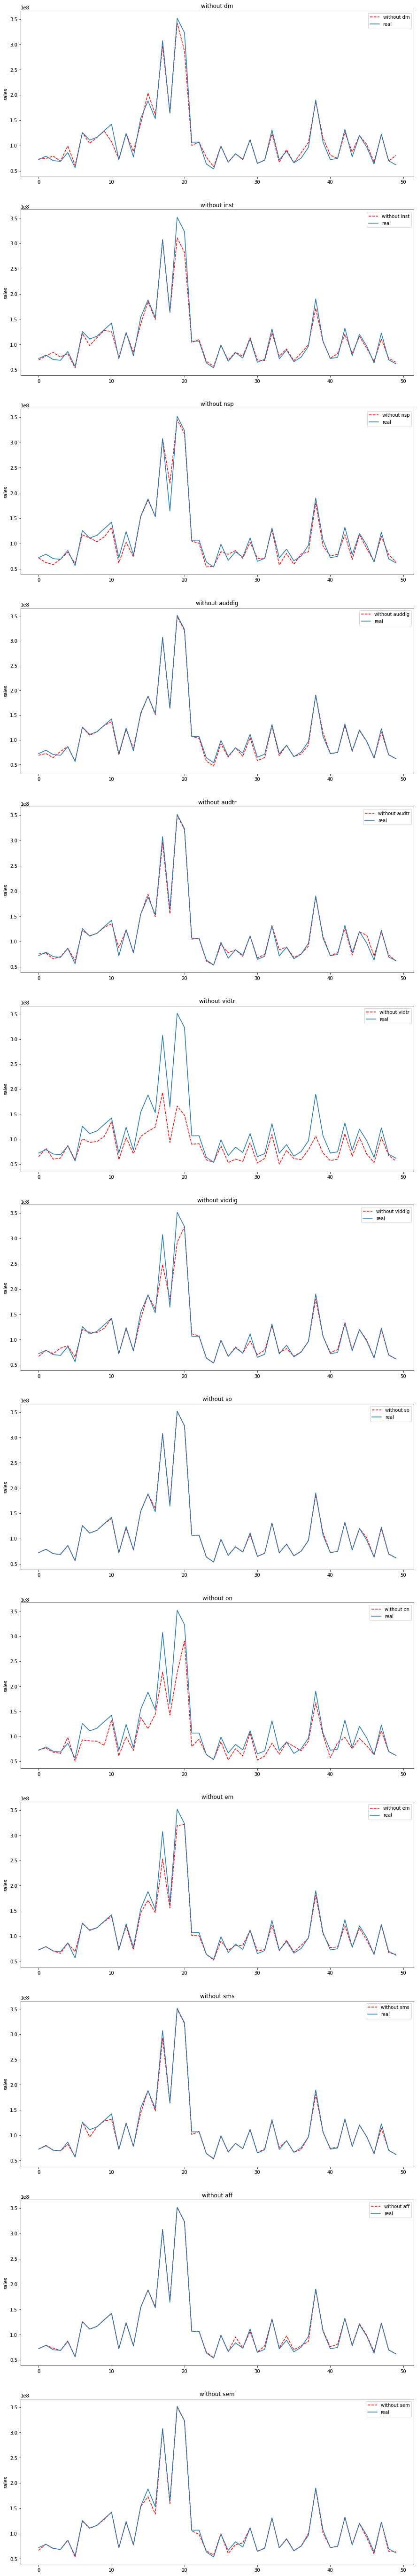

In [190]:
fig, ax = plt.subplots(13, 1, figsize=(15, 100))
for i in range(len(new_sales)):
    plt.subplot(13, 1, i+1)
    plt.title(chanels_names[i])
    plt.plot(np.arange(50), new_sales[i][:50],'--',  label=chanels_names[i], color = 'red')
    plt.plot(np.arange(50), y[:50], label='real')
    plt.ylabel('sales')
    plt.legend()

По итогам самым эффективным оказался канал vidtr, а самым неэффективным - dm

### 3 Задание

#### 3.1 ROAS
1) общий ROAS

In [191]:
chanels_names = [i[12:] for i in impres]
for i in range(len(new_sales)):
    if 'costs_' + chanels_names[i] in data.columns:
        roas = np.average(y - new_sales[i])/np.average(data['costs_' + chanels_names[i]])
        print(f'ROAS for {chanels_names[i]} = {roas}')

ROAS for dm = -2.3500785284578787
ROAS for inst = 23.98875601328258
ROAS for nsp = 9.076664399096934
ROAS for auddig = 88.31274316940275
ROAS for audtr = -4.61649804189286
ROAS for vidtr = 132.16965292533447
ROAS for viddig = 113.19092720387849
ROAS for so = -6.732590468952269
ROAS for on = 88.89055982672436
ROAS for sem = 3.6941034673064492


2) недельный ROAS

In [193]:
roas_week  = {}
for i in range(len(new_sales)):
    if 'costs_' + chanels_names[i] in data.columns:
        roas_week[chanels_names[i]] = []
        for j in range(len(data)):
            if data.loc[j, 'costs_' + chanels_names[i]] != 0:
                roas = (y[j] - new_sales[i][j])/(data.loc[j, 'costs_' + chanels_names[i]])
                roas_week[chanels_names[i]].append(roas)

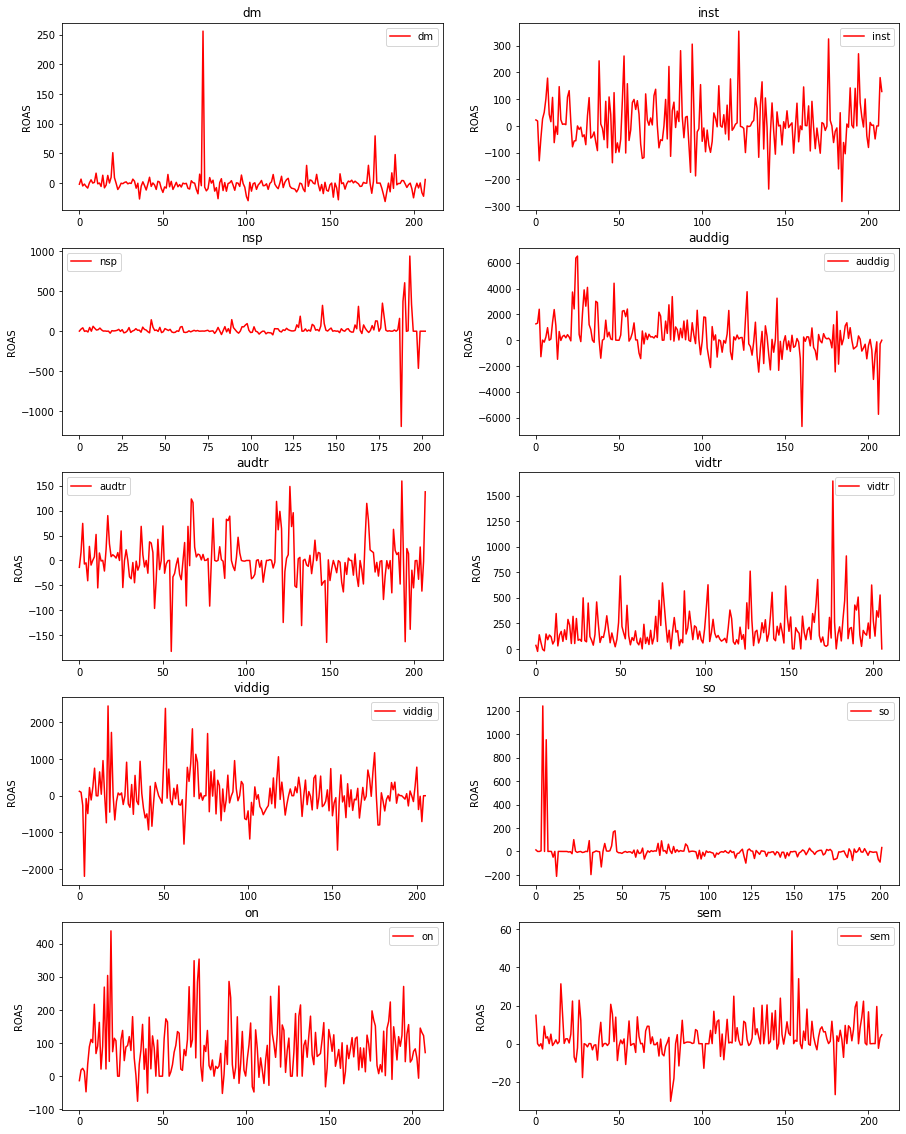

In [194]:
fig, ax = plt.subplots(5, 2, figsize=(15, 20))
for i in range(len(roas_week)):
    name = list(roas_week.keys())[i]
    values = roas_week[name]
    plt.subplot(5, 2, i+1)
    plt.title(name)
    plt.plot(np.arange(len(values)), values,  label=name, color = 'red')
    plt.ylabel('ROAS')
    plt.legend()

#### 3.2 IROAS
1) общий

In [195]:
iroas_week = {}
for i in range(len(chanels_names)):
    if 'costs_' + chanels_names[i] in data.columns:
        X_n = X.copy()[X['costs_' + chanels_names[i]] != 0]
        dif = X_n['costs_' + chanels_names[i]]*1.01 - X_n['costs_' + chanels_names[i]]
        X_n['costs_' + chanels_names[i]] = X_n['costs_' + chanels_names[i]]*1.01
        pred = model.predict(X_n)
        print(f'IROAS for {chanels_names[i]} = {np.average(pred/dif)}')
        iroas_week[chanels_names[i]] = pred/dif

IROAS for dm = 160742.9439839721
IROAS for inst = 244877.76033113862
IROAS for nsp = 1721873.0396882899
IROAS for auddig = 4095535.2655073204
IROAS for audtr = 522700.0651199938
IROAS for vidtr = 232483.06409476267
IROAS for viddig = 1805246.41377858
IROAS for so = 558774.1933852328
IROAS for on = 62159.65143049056
IROAS for sem = 21068.032536612445


2) недельный IROAS

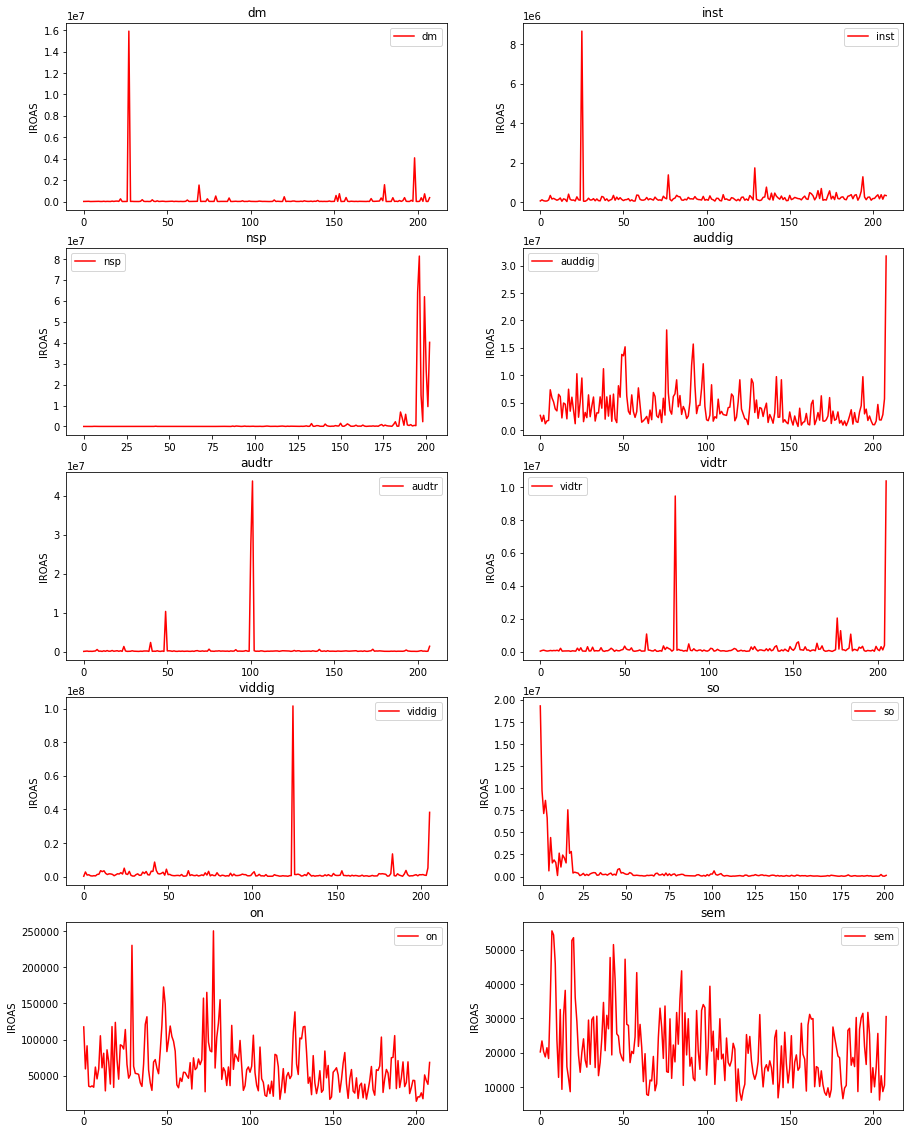

In [196]:
fig, ax = plt.subplots(5, 2, figsize=(15, 20))
for i in range(len(iroas_week)):
    name = list(iroas_week.keys())[i]
    values = iroas_week[name]
    plt.subplot(5, 2, i+1)
    plt.title(name)
    plt.plot(np.arange(len(values)), values,  label=name, color = 'red')
    plt.ylabel('IROAS')
    plt.legend()